# MICRO SPRITE GENERATOR
Tests architecture for text-to-image generative model

---

### Setup

In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
import random
import os
import json
from matplotlib.colors import ListedColormap

# tensorflow
# import tensorflow as tf
# from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras import optimizers
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import InputLayer, Dense, Conv2D, Conv2DTranspose, Flatten
from tensorflow.keras.models import Model


%matplotlib inline

CONSTANTS and GLOBALS

In [2]:
# CONSTANT VARIABLES

# PICO-8 Palette => use colormap for matplotlib
PICO_PALETTE = ['#000000','#1D2B53','#7E2553','#008751','#AB5236','#5F574F','#C2C3C7','#FFF1E8','#FF004D','#FFA300','#FFEC27','#00E436','#29ADFF','#83769C','#FF77A8','#FFCCAA']


GENERAL UTILITY FUNCTIONS

In [30]:
##  RENDER FUNCTIONS  ##

# show a single sprite - using a specified palette (form (NxN))
def showSprPalette(spr,palette=PICO_PALETTE):
    #set the colormap
    colormap = ListedColormap(palette,N=len(palette))

    #show the sprite
    plt.figure(figsize=(2,2))
    plt.axis('off')
    plt.imshow(spr.squeeze(),cmap=colormap,vmin=0,vmax=len(palette)-1)
    plt.show()


# show a list of sprites - using a specified palette (form Ax(NxN))
def showMultiSprPalette(sprs,palette=PICO_PALETTE,text='',textArr=None):
    #set the colormap
    colormap = ListedColormap(palette,N=len(palette))

    #show sprites (8 per row)
    plt.figure(figsize=(20,7))
    col = 8
    for i, im in enumerate(sprs):
        plt.subplot(int(len(sprs) / col) + 1, col, i + 1)
        plt.imshow(im.squeeze(),cmap=colormap,vmin=0,vmax=len(palette)-1)
        plt.axis('off')

        #add sublabels
        if (textArr != None) and (i < len(textArr)):
            addtext = ""
            #sub label + title on middle entry
            if text != '' and i == (min(len(sprs),col)//2):
                addtext = f"{text.upper()}\n"
            plt.title(f"{addtext}{textArr[i]}")
            
        #add plot title only
        else:
            if text != '' and i == (min(len(sprs),col)//2):
                plt.title(text.upper())
    plt.show()

# show a single sprite - using RGB (form (NxNx3))
def showSprRGB(spr):
    #show the sprite
    plt.figure(figsize=(2,2))
    plt.axis('off')
    plt.imshow(spr.squeeze())
    plt.show()

# show a list of sprites - using RGB (form Ax(NxNx3))
def showMultiSprRGB(sprs,text='',textArr=None):
    #show sprites (8 per row)
    plt.figure(figsize=(20,7))
    col = 8
    for i, im in enumerate(sprs):
        plt.subplot(int(len(sprs) / col) + 1, col, i + 1)
        plt.imshow(im.squeeze())
        plt.axis('off')

        #add sublabels
        if (textArr != None) and (i < len(textArr)):
            addtext = ""
            #sub label + title on middle entry
            if text != '' and i == (min(len(sprs),col)//2):
                addtext = f"{text.upper()}\n"
            plt.title(f"{addtext}{textArr[i]}")
            
        #add plot title only
        else:
            if text != '' and i == (min(len(sprs),col)//2):
                plt.title(text.upper())
    plt.show()




##  DATA PROCESSING FUNCTIONS  ##

# encode a sprite to one-hot array based on a palette (form (NxN) => (NxNxP)))
def encodeSpr1H(s,channels=len(PICO_PALETTE)):
    spr3d = np.zeros((s.shape[0],s.shape[1],channels))
    for r in range(s.shape[0]):
        for c in range(s.shape[1]):
            v = s[r][c]
            spr3d[r][c][v] = 1
    return spr3d
    
#convert 3d encoded channel map into 2d array format
def decodeSpr1H(s3c):
    return np.argmax(s3c,axis=2)
    

IMPORT DATASETS

Food Dataset shape: (100, 8, 8)
Char Dataset shape: (100, 8, 8)


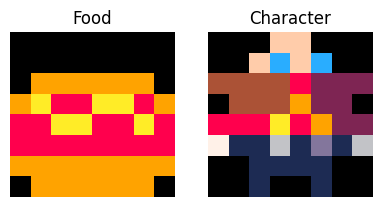

In [4]:
# import from the PICO sprites posted onto Twitter 
# Food: https://twitter.com/JUSTIN_CYR/status/634546317713391616
# Characters: https://twitter.com/johanvinet/status/635814153601597441
pico_food_dat = np.load('../data/rip_data/pico_food.npy',allow_pickle=True)
pico_char_dat = np.load('../data/rip_data/pico_characters.npy',allow_pickle=True)

print(f"Food Dataset shape: {pico_food_dat.shape}")
print(f"Char Dataset shape: {pico_char_dat.shape}")

# show a random food and character sprite 
rand_food = random.choice(pico_food_dat)
rand_char = random.choice(pico_char_dat)
showMultiSprPalette([rand_food,rand_char],textArr=['Food','Character'])

### GENERATIVE MODEL EXPERIMENT 

In [96]:
##  BASIC AUTOENCODER  ##

class PICOAutoencoder(Model):
    def __init__(self,in_shape,show_summary=False):
        super(PICOAutoencoder, self).__init__()
        self.encoder = Sequential([
            InputLayer(input_shape=in_shape),
            Conv2D(64, (2,2), strides=2, activation='relu', padding='same'),
            Conv2D(32, (2,2), strides=2, activation='relu', padding='same'),
            Conv2D(16, (2,2), strides=2, activation='relu', padding='same')])

        self.decoder = Sequential([
            InputLayer(input_shape=self.encoder.output_shape[1:]),
            Conv2DTranspose(16, (2,2), strides=2, activation='relu', padding='same'),
            Conv2DTranspose(32, (2,2), strides=2, activation='relu', padding='same'),
            Conv2DTranspose(64, (2,2), strides=2, activation='relu', padding='same'),
            # Conv2D(in_shape[-1], (3,3), activation='sigmoid', padding='same')])
            Conv2D(in_shape[-1], (3,3), activation='softmax', padding='same')])
        

        if show_summary:
            print("== ENCODER ==")
            self.encoder.summary()
            print("")
            print("== DECODER ==")
            self.decoder.summary()
        

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

    def exportEnc(self, name):
        if not os.path.exists("../models/gen_models/autoencoders/"):
            os.mkdir("../models/gen_models/autoencoders/")
        self.encoder.save(f"../models/gen_models/autoencoders/{name}_encoder.h5")

    def exportDec(self, name):
        if not os.path.exists("../models/gen_models/autoencoders/"):
            os.mkdir("../models/gen_models/autoencoders/")
        self.decoder.save(f"../models/gen_models/autoencoders/{name}_decoder.h5")

    def importDec(self,name):
        self.decoder = load_model(f"../models/gen_models/autoencoders/{name}_decoder.h5")
        
    def importEnc(self,name):
        self.encoder = load_model(f"../models/gen_models/autoencoders/{name}_encoder.h5")

Autoencoder Dataset shape: (100, 8, 8, 16)
== ENCODER ==
Model: "sequential_84"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_178 (Conv2D)         (None, 4, 4, 64)          4160      
                                                                 
 conv2d_179 (Conv2D)         (None, 2, 2, 32)          8224      
                                                                 
 conv2d_180 (Conv2D)         (None, 1, 1, 16)          2064      
                                                                 
Total params: 14,448
Trainable params: 14,448
Non-trainable params: 0
_________________________________________________________________

== DECODER ==
Model: "sequential_85"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_transpose_135 (Conv2  (None, 2, 2, 16)         1040      
 DTranspose)        

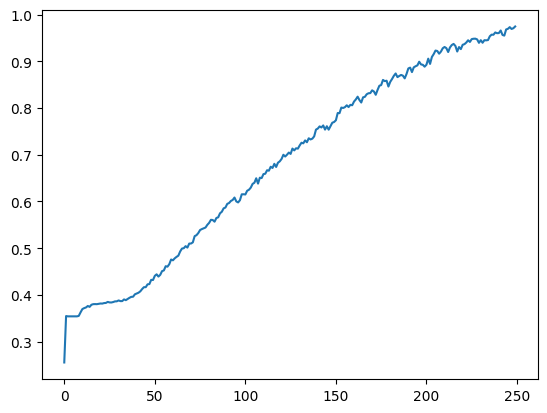

In [205]:
# setup the dataset
# pico_ae_dat = np.concatenate((pico_food_dat,pico_char_dat),axis=0)  # combine food and character datasets
pico_ae_dat = pico_char_dat

pico_ae_dat = np.array([encodeSpr1H(s) for s in pico_ae_dat])   # encode to 1-hot
np.random.shuffle(pico_ae_dat)                                  # shuffle the dataset
print(f"Autoencoder Dataset shape: {pico_ae_dat.shape}")

# setup the model
pico_ae_model = PICOAutoencoder((8,8,len(PICO_PALETTE)),True)
# pico_ae_model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])
pico_ae_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# train the model
EPOCHS = 250
BATCH_SIZE = 16
h = pico_ae_model.fit(pico_ae_dat, pico_ae_dat, batch_size=BATCH_SIZE,epochs=EPOCHS,shuffle=True)

#plot the accuracy over time
plt.plot(h.history['accuracy'])


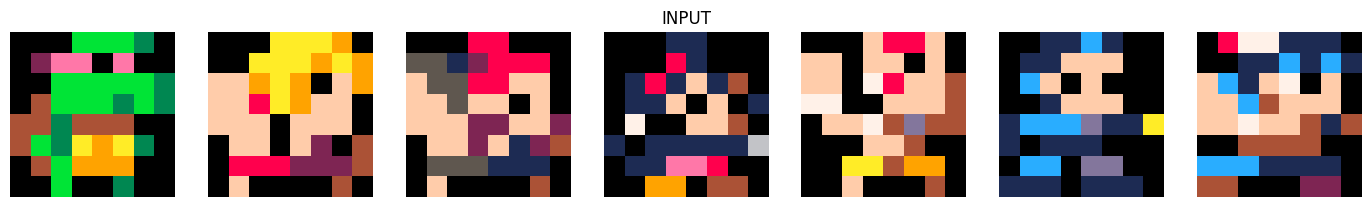

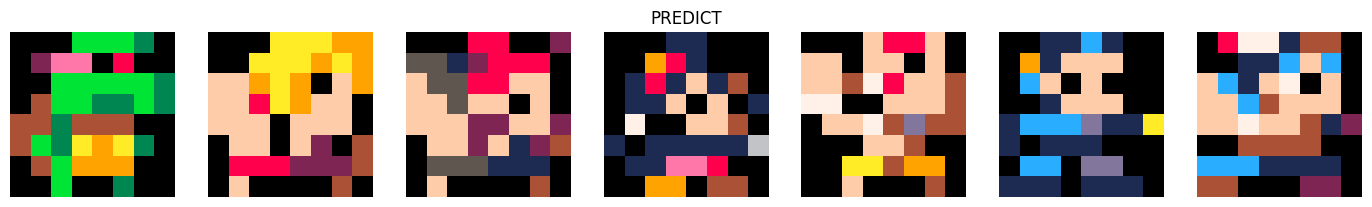

In [206]:
# test output
ae_test_set = random.choices(pico_ae_dat, k=7)
ae_test_set = np.array(ae_test_set)

showMultiSprPalette([decodeSpr1H(s) for s in ae_test_set],text='INPUT')
showMultiSprPalette([decodeSpr1H(s) for s in pico_ae_model.predict(ae_test_set,verbose=False)],text='PREDICT')


(7, 1, 1, 16)


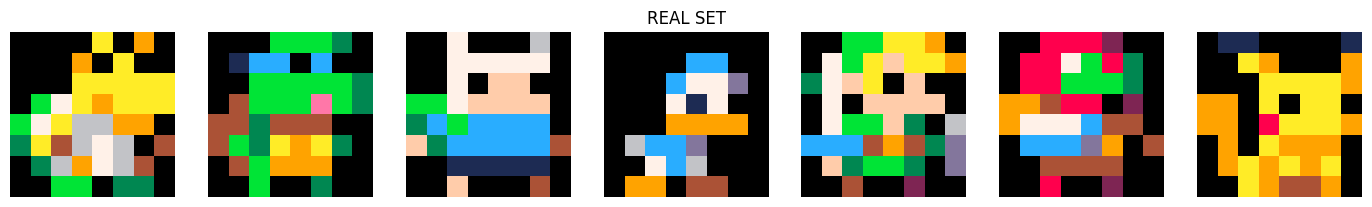

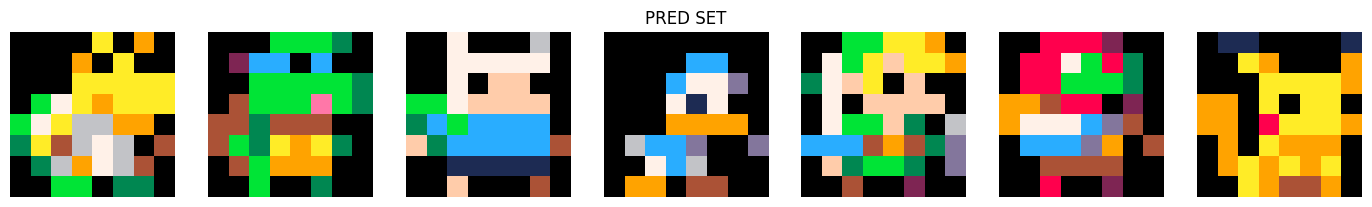

In [218]:
# random sampling

# show some final outputs from real data
real_set = [7,30,53,86,90,96,99]    
real_set_label = ['Koopa','Donatello','Finn','Dewey','Link','Samus','Pikachu']
real_oh_set = np.array([encodeSpr1H(s) for s in pico_char_dat[real_set]])

real_enc = pico_ae_model.encoder.predict(real_oh_set,verbose=False)
real_dec = pico_ae_model.decoder.predict(real_enc,verbose=False)

print(real_enc.shape)

showMultiSprPalette([pico_char_dat[i] for i in real_set],text='Real set')
showMultiSprPalette([decodeSpr1H(s) for s in real_dec],text='Pred set')


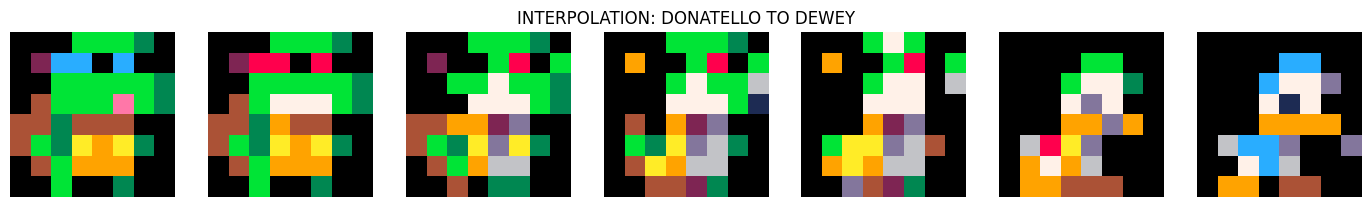

In [220]:
# shift from one character to another

def interpolateVec(v1,v2,steps):
    return [v1 + (v2-v1)*i/(steps-1) for i in range(steps)]

pick2 = random.sample(range(len(real_enc)), k=2)
inter_vec = interpolateVec(real_enc[pick2[0]],real_enc[pick2[1]],7) 
inter_pred = pico_ae_model.decoder.predict(np.array(inter_vec),verbose=False)
showMultiSprPalette([decodeSpr1H(s) for s in inter_pred],text=f'Interpolation: {real_set_label[pick2[0]]} to {real_set_label[pick2[1]]}')


In [221]:
# compare between 2 groups of similar characters (ninja turtles + duck tales)
ninja_turtles = [30,31,32,33]
duck_tales = [84,85,86,87]

ninja_oh = np.array([encodeSpr1H(s) for s in pico_char_dat[ninja_turtles]])
duck_oh = np.array([encodeSpr1H(s) for s in pico_char_dat[duck_tales]])

ninja_enc = pico_ae_model.encoder.predict(ninja_oh,verbose=False)
duck_enc = pico_ae_model.encoder.predict(duck_oh,verbose=False)

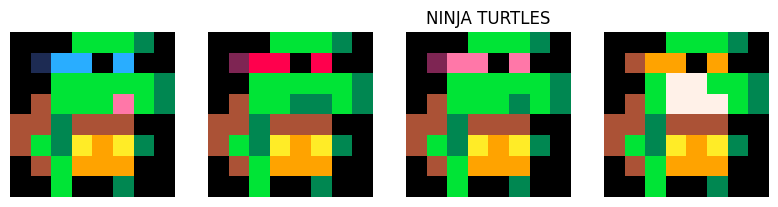

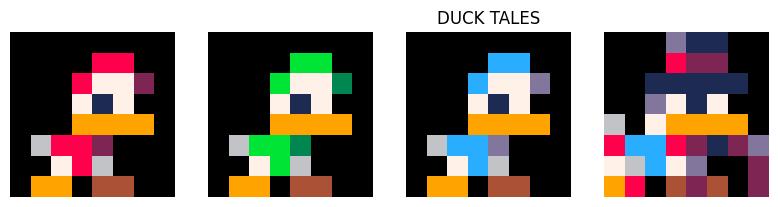

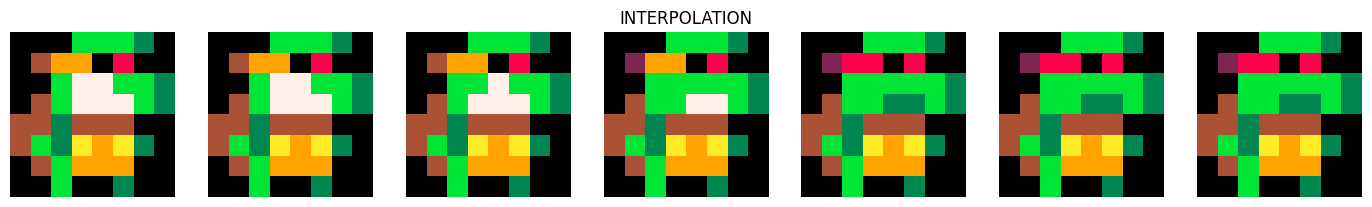

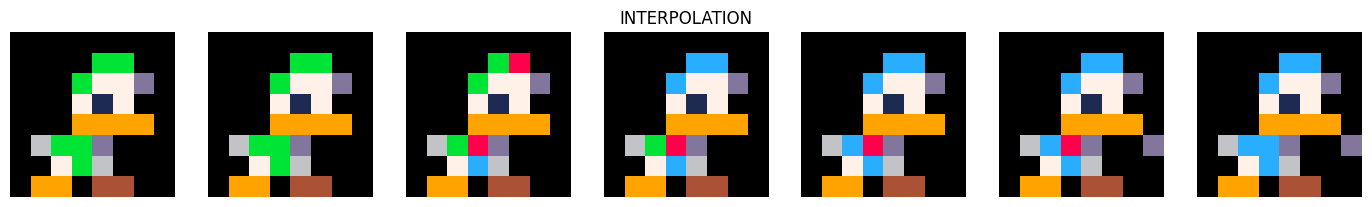

In [230]:
showMultiSprPalette([pico_char_dat[i] for i in ninja_turtles],text='Ninja Turtles')
showMultiSprPalette([pico_char_dat[i] for i in duck_tales],text='Duck Tales')

# interpolate between 2 random turtles and 2 random ducks
for a in [ninja_enc,duck_enc]:
    pick2 = random.sample(range(len(a)), k=2)
    inter_vec = interpolateVec(a[pick2[0]],a[pick2[1]],7)
    inter_pred = pico_ae_model.decoder.predict(np.array(inter_vec),verbose=False)
    showMultiSprPalette([decodeSpr1H(s) for s in inter_pred],text=f'Interpolation')

In [201]:
# retrieve range of each element from the encoding vector 
enc_vec_set = pico_ae_model.encoder.predict(pico_ae_dat,verbose=False)
enc_vec_min_max = np.array([[np.min(enc_vec_set[:,:,i,j]),np.max(enc_vec_set[:,:,i,j])] for i in range(enc_vec_set.shape[2]) for j in range(enc_vec_set.shape[3])])

print(enc_vec_min_max.shape)  #should be (1,16,2)
print(enc_vec_min_max)
 


(16, 2)
[[  0.93523026 222.0659    ]
 [  0.         173.56053   ]
 [  2.0184238  273.97604   ]
 [  0.         212.41785   ]
 [  0.         311.12335   ]
 [  0.           0.        ]
 [  0.         232.72699   ]
 [  2.9373052  298.1779    ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  1.5205781  224.14082   ]
 [  0.50582504 198.08095   ]
 [  0.           0.        ]
 [  0.         264.87955   ]
 [  0.          85.15058   ]
 [  0.           0.        ]]


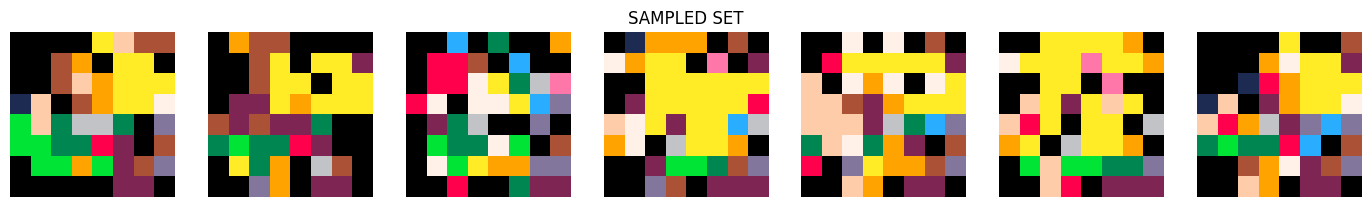

In [214]:
# sample from this space and show output
sample_set = []
for i in range(7):
    sample = np.array([np.random.uniform(enc_vec_min_max[i][0],enc_vec_min_max[i][1]) for i in range(16)])
    sample = np.expand_dims(sample,0)
    sample = np.expand_dims(sample,0)
    sample_set.append(sample)
sample_set = np.array(sample_set)
pred_samp_set = pico_ae_model.decoder.predict(sample_set,verbose=False)

showMultiSprPalette([decodeSpr1H(s) for s in pred_samp_set],text='Sampled set')


In [204]:
# export the model
pico_ae_model.exportEnc(f'pico_ae-[char100p]-{EPOCHS}')
pico_ae_model.exportDec(f'pico_ae-[char100p]-{EPOCHS}')

In [56]:
##  BASIC VAE  ##

